In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import mannwhitneyu
nltk.download('all')

/Users/aimeeoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/aimeeoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/aimeeoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/aimeeoh/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading pac

True

In [2]:
data = pd.read_csv('data/juniper-bar/csv/detailed-reviews-of-juniper-bar.csv')

df = data[['place_name', 'rating', 'review_text', 'published_at_date']]
df

,place_name,rating,review_text,published_at_date
0,Juniper Bar,5,Great spot for before a Knicks game. The Phill...,2024-02-29 11:06:55.457556
1,Juniper Bar,4,Layout/atmosphere *Long bar with three TVs and...,2024-02-24 11:06:55.473424
2,Juniper Bar,5,"Had a blast, definitely most go back",2024-02-24 11:06:55.481803
3,Juniper Bar,5,NaN,2024-02-24 11:06:55.492449
4,Juniper Bar,5,"In my experience, this is the best Happy Hour ...",2024-02-24 11:06:55.499516
...,...,...,...,...
1044,Juniper Bar,5,NaN,2016-03-02 11:09:56.548433
1045,Juniper Bar,5,NaN,2016-03-02 11:09:56.550488
1046,Juniper Bar,5,NaN,2016-03-02 11:09:56.553831
1047,Juniper Bar,5,Food drinks service top notch.,2016-03-02 11:09:56.555926


Extracting Year from 'published_at_date' column

In [3]:
df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_33779/2592446673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['published_at_date'] = pd.to_datetime(df['published_at_date']).dt.year


,place_name,rating,review_text,published_at_date
0,Juniper Bar,5,Great spot for before a Knicks game. The Phill...,2024
1,Juniper Bar,4,Layout/atmosphere *Long bar with three TVs and...,2024
2,Juniper Bar,5,"Had a blast, definitely most go back",2024
3,Juniper Bar,5,NaN,2024
4,Juniper Bar,5,"In my experience, this is the best Happy Hour ...",2024
...,...,...,...,...
1044,Juniper Bar,5,NaN,2016
1045,Juniper Bar,5,NaN,2016
1046,Juniper Bar,5,NaN,2016
1047,Juniper Bar,5,Food drinks service top notch.,2016


Charts for ratings

<AxesSubplot:xlabel='rating'>

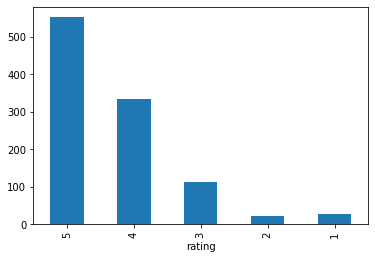

In [4]:
df['rating'].value_counts()[[5, 4, 3, 2, 1]].plot(kind='bar')

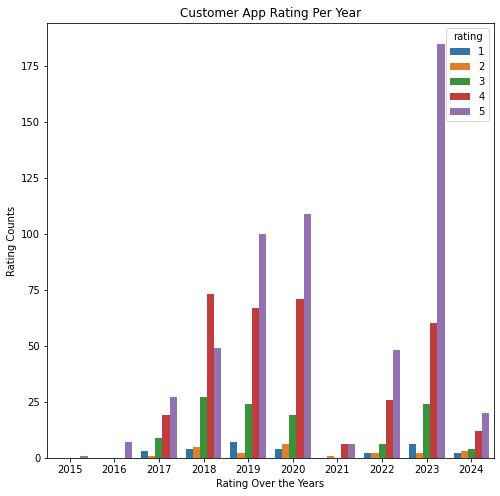

In [5]:
plt.figure(figsize=(8, 8))
sns.countplot(x = 'published_at_date', hue ='rating', data = df)
plt.title('Customer App Rating Per Year')
plt.xlabel("Rating Over the Years")
plt.ylabel('Rating Counts')
plt.show()

In [6]:
df['review_text'] = df['review_text'].astype("string")

df[['review_text']]

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_33779/2693296585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_text'] = df['review_text'].astype("string")


,review_text
0,Great spot for before a Knicks game. The Phill...
1,Layout/atmosphere *Long bar with three TVs and...
2,"Had a blast, definitely most go back"
3,<NA>
4,"In my experience, this is the best Happy Hour ..."
...,...
1044,<NA>
1045,<NA>
1046,<NA>
1047,Food drinks service top notch.


In [7]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
stop_words_file = 'Stopwords.txt'

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [8]:
prep = []

for text in df['review_text']:
    if pd.isna(text):
        prep.append('')
    else:
        prep.append(preprocess(text))

df['prep'] = prep

df.head()

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_33779/1628437642.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prep'] = prep


,place_name,rating,review_text,published_at_date,prep
0,Juniper Bar,5,Great spot for before a Knicks game. The Phill...,2024,great spot knick game philli chees steak egg r...
1,Juniper Bar,4,Layout/atmosphere *Long bar with three TVs and...,2024,layout atmospher long bar tv high tabl rais ba...
2,Juniper Bar,5,"Had a blast, definitely most go back",2024,blast back
3,Juniper Bar,5,<NA>,2024,
4,Juniper Bar,5,"In my experience, this is the best Happy Hour ...",2024,experi happi hour midtown absolut inexpens gre...


In [9]:
from collections import Counter
Counter(" ".join(df["prep"]).split()).most_common(50)

[('food', 262),
 ('great', 260),
 ('good', 209),
 ('drink', 186),
 ('bar', 141),
 ('servic', 138),
 ('place', 136),
 ('hour', 99),
 ('happi', 98),
 ('nice', 91),
 ('atmospher', 67),
 ('staff', 58),
 ('delici', 58),
 ('back', 57),
 ('burger', 55),
 ('time', 52),
 ('order', 51),
 ('cocktail', 43),
 ('fri', 42),
 ('price', 41),
 ('spot', 39),
 ('love', 39),
 ('friendli', 38),
 ('amaz', 37),
 ('work', 34),
 ('recommend', 34),
 ('bartend', 33),
 ('excel', 33),
 ('junip', 33),
 ('menu', 32),
 ('pretti', 32),
 ('music', 31),
 ('loud', 31),
 ('tabl', 29),
 ('dinner', 29),
 ('chees', 28),
 ('didnt', 27),
 ('attent', 26),
 ('crowd', 25),
 ('make', 25),
 ('slider', 25),
 ('msg', 25),
 ('area', 24),
 ('event', 24),
 ('lunch', 24),
 ('busi', 23),
 ('night', 23),
 ('reserv', 23),
 ('eat', 23),
 ('wing', 23)]

In [10]:
def create_sentiment(rating):
    
    if rating==1 or rating==2:
        return -1 # negative sentiment
    elif rating==4 or rating==5:
        return 1 # positive sentiment
    else:
        return 0 # neutral sentiment

df['sentiment'] = df['rating'].apply(create_sentiment)
df

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_33779/1400198503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(create_sentiment)


,place_name,rating,review_text,published_at_date,prep,sentiment
0,Juniper Bar,5,Great spot for before a Knicks game. The Phill...,2024,great spot knick game philli chees steak egg r...,1
1,Juniper Bar,4,Layout/atmosphere *Long bar with three TVs and...,2024,layout atmospher long bar tv high tabl rais ba...,1
2,Juniper Bar,5,"Had a blast, definitely most go back",2024,blast back,1
3,Juniper Bar,5,<NA>,2024,,1
4,Juniper Bar,5,"In my experience, this is the best Happy Hour ...",2024,experi happi hour midtown absolut inexpens gre...,1
...,...,...,...,...,...,...
1044,Juniper Bar,5,<NA>,2016,,1
1045,Juniper Bar,5,<NA>,2016,,1
1046,Juniper Bar,5,<NA>,2016,,1
1047,Juniper Bar,5,Food drinks service top notch.,2016,food drink servic top notch,1


<AxesSubplot:xlabel='sentiment', ylabel='count'>

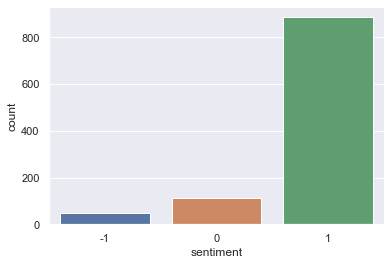

In [11]:
sns.set_theme()

# Create a visualization
sns.countplot(
    data=df,
    x="sentiment"
)

In [12]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return scores['compound']




# apply get_sentiment function

df['review_sentiment'] = df['prep'].apply(get_sentiment)

df['review_sentiment']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_33779/3818571148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_sentiment'] = df['prep'].apply(get_sentiment)


0       0.6249
1       0.9403
2       0.0000
3       0.0000
4       0.9552
         ...  
1044    0.0000
1045    0.0000
1046    0.0000
1047    0.2023
1048    0.9081
Name: review_sentiment, Length: 1049, dtype: float64

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False,
                        preprocessor=None)

X = tfidf.fit_transform(df['prep'])

years = df['published_at_date']

from sklearn.model_selection import train_test_split
y = df['sentiment'] # target variable
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(X,y, years)

In [14]:
# SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

clf = LinearSVC(random_state=0)

clf.fit(X_train,y_train)

y_test_pred=clf.predict(X_test)

report=classification_report(y_test, y_test_pred, output_dict=True)
report

{'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12},
 '0': {'precision': 0.75,
  'recall': 0.08823529411764706,
  'f1-score': 0.15789473684210525,
  'support': 34},
 '1': {'precision': 0.8372093023255814,
  'recall': 0.9953917050691244,
  'f1-score': 0.9094736842105263,
  'support': 217},
 'accuracy': 0.8326996197718631,
 'macro avg': {'precision': 0.5290697674418605,
  'recall': 0.36120899972892384,
  'f1-score': 0.3557894736842105,
  'support': 263},
 'weighted avg': {'precision': 0.7877354319568486,
  'recall': 0.8326996197718631,
  'f1-score': 0.770814488693216,
  'support': 263}}

In [15]:
y_test

771     1
944     0
346     1
1000    0
740     1
       ..
281     1
1031    1
2       1
888     1
273     1
Name: sentiment, Length: 263, dtype: int64

In [16]:
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency

predictions_df = pd.DataFrame({'Sentiment': y_test_pred, 'Years': years_test})

# Create a contingency table
contingency_table = pd.crosstab(predictions_df['Sentiment'], predictions_df['Years'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square statistic:", chi2_stat)
print("Degrees of freedom:", dof)
print("p-value:", p_val)
print("Expected frequencies:\n", expected)
print("Contingency table:\n", contingency_table)

Chi-square statistic: 15.180161938201232
Degrees of freedom: 16
p-value: 0.5114848608949922
Expected frequencies:
 [[7.60456274e-03 7.60456274e-02 1.40684411e-01 1.93916350e-01
  2.20532319e-01 3.80228137e-03 7.60456274e-02 2.43346008e-01
  3.80228137e-02]
 [3.04182510e-02 3.04182510e-01 5.62737643e-01 7.75665399e-01
  8.82129278e-01 1.52091255e-02 3.04182510e-01 9.73384030e-01
  1.52091255e-01]
 [1.96197719e+00 1.96197719e+01 3.62965779e+01 5.00304183e+01
  5.68973384e+01 9.80988593e-01 1.96197719e+01 6.27832700e+01
  9.80988593e+00]]
Contingency table:
 Years      2016  2017  2018  2019  2020  2021  2022  2023  2024
Sentiment                                                      
-1            0     0     1     0     0     0     0     0     0
 0            0     0     1     0     2     0     0     0     1
 1            2    20    35    51    56     1    20    64     9


In [17]:
# Wilcoxon rank-sum / Mann-whitney U Test
year = 2017

before_data = df[df['published_at_date'] < year]
after_data = df[df['published_at_date'] >= year]

u_stat, p_value_mw = mannwhitneyu(before_data['review_sentiment'], after_data['review_sentiment'])
print("Mann-Whitney U test - U-statistic:", u_stat, "p-value:", p_value_mw)

Mann-Whitney U test - U-statistic: 4877.0 p-value: 0.3590305802524476


In [18]:
# make altered data into csv file
df.to_csv('altdata/' + 'juniper.csv', index=False)